# Notebook of the project of Physics of Complex Systems #

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import seaborn as sns

import aux      # it's a file with some generic auxiliary functions I often use

In [2]:
# set the seed
np.random.seed(12345)

# I set some parameters for the whole project
time_steps = 200    # 1000

# Set the time grid for the ODEs
t_s = np.linspace(0,time_steps,time_steps)

# parameters initialization (I use the parameters listed in the caption of Figure 3)
par = {
    'alpha': 1.2,
    'gamma': 0.1,   # questo sarebbe 0.01
    'lambda': 0.4,
    'nu': 0.004,
    'sigma': 0.1,
    'Dx': 0.,       # diffusion of x
    'Dy': 0.        # diffusion of y
}

# Define some meaningful quantities for the analysis
y0 = par['lambda']/par['sigma']
y_star = par['alpha']/par['gamma']
x_star = (par['sigma']-par['lambda']*par['gamma']/par['alpha'])/par['nu']

# In which regime are we?
print(f'In which regime are we? {'First regime:(0,y_0) unstable, (x^*,y^*) stable' \
    if par['alpha']>(par['lambda']*par['gamma']/par['sigma']) else 'Second regime:(0,y_0) stable, (x^*,y^*)unstable'}')

In which regime are we? First regime:(0,y_0) unstable, (x^*,y^*) stable


In [3]:
# Some utility functions
def check_sign(cell):
    # If in any cell x or y are negative, set it to zero
    if cell[0] < 0:
        cell[0] = 0
        
    if cell[1] < 0:
        cell[1] = 0

# function to add a parameter box to the 
def add_par_box(par):
    # Add a parameter box to the plot
    textstr = '\n'.join((
    r'$\alpha=%.2f$' % (par['alpha'], ),
    r'$\gamma=%.2f$' % (par['gamma'], ),
    r'$\lambda=%.2f$' % (par['lambda'], ),
    r'$\nu=%.2e$' % (par['nu'], ),
    r'$\sigma=%.2f$' % (par['sigma'], )))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.3)

    # place a text box in the best spot in axes coords
    plt.gca().text(0.98, 0.60, textstr, transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right', bbox=props)

Firstly, I try to reproduce the mean-field approach. The resulting system of ODEs is the following:
$$
    \frac{\partial x}{\partial t} = \alpha x - \gamma xy , \;\;\;
    \frac{\partial y}{\partial t} = \lambda + \nu xy - \sigma y
$$
where $x$ is the pathogen concentration and $y$ lymphocytes'. \
The parameters represent:
- $\alpha$ : proliferation rate of the pathogen; 
- $\gamma$ : destruction rate of the pathogen by the lymphocytes; 
- $\lambda$ : birth rate of the lymphocyte; 
- $\nu$ : duplication rate of the lymphocyte when encountering the pathogen; 
- $\sigma$ : death rate of the lymphocyte. 


## Mean Field Approach ##

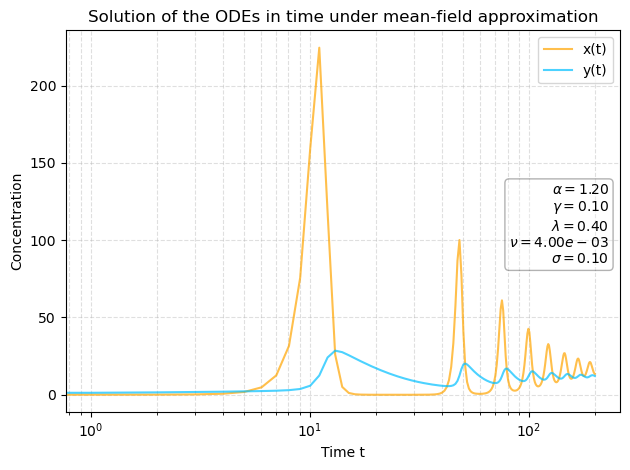

In [4]:
# set initial conditions
z0 = np.array([0.01,np.random.poisson(lam=1)])    # z=[x,y]
#z0 = np.array([x_star,y_star])    # z=[x*,y*] (I try to initialize at a fixed point to verify stability)

'''
# parameters initialization (I use the parameters listed in the caption of Figure 3)
par = {
    'alpha': 1.6,
    'gamma': 0.01,   # questo sarebbe 0.01
    'lambda': 0.6,
    'nu': 0.001,
    'sigma': 0.01,
    'Dx': 0.,
    'Dy': 0.
}
'''

def system(z:np.ndarray ,t:np.ndarray ,par:dict):
    
    x, y = z
    dxdt = par['alpha']*x - par['gamma']*x*y
    dydt = par['lambda'] + par['nu']*x*y - par['sigma']*y
    return [dxdt,dydt]

# Solve
X_ode = odeint(system,z0,t_s,args=(par,))[:,0]
Y_ode = odeint(system,z0,t_s,args=(par,))[:,1]

'''
# Normalization
X_ode = X_ode/np.mean(X_ode)
Y_ode = X_ode/np.mean(Y_ode)
'''
# Solution of the X ODE
#plt.figure(figsize=(12,8))
plt.plot(t_s, X_ode, c='orange', label='x(t)',alpha=0.7)
plt.plot(t_s, Y_ode, c='deepskyblue', label='y(t)',alpha=0.7)
plt.title('Solution of the ODEs in time under mean-field approximation')
plt.xlabel('Time t')
plt.ylabel('Concentration')
plt.xscale('log')
plt.grid(True, which="both",alpha=0.4,linestyle='--')
add_par_box(par)
plt.legend()
plt.tight_layout()
plt.show()


Now I recreate the trajectory of the solutions of the ODE

In which regime are we? First regime:(0,y_0) unstable, (x^*,y^*) stable


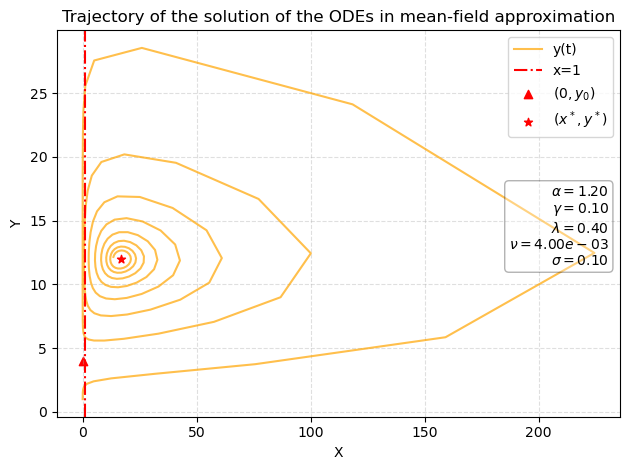

In [ ]:
'''
# parameters initialization (I use the parameters listed in the caption of Figure 3)
par = {
    'alpha': 1.2,
    'gamma': 0.1,   # questo sarebbe 0.01
    'lambda': 0.4,
    'nu': 0.004,
    'sigma': 0.1,
    'Dx': 0.,       # diffusion of x
    'Dy': 0.        # diffusion of y
}
'''
# Define some meaningful quantities for the analysis
y0 = par['lambda']/par['sigma']
y_star = par['alpha']/par['gamma']
x_star = (par['sigma']-par['lambda']*par['gamma']/par['alpha'])/par['nu']

# In which regime are we?
print(f'In which regime are we? {'First regime:(0,y_0) unstable, (x^*,y^*) stable' \
    if par['alpha']>(par['lambda']*par['gamma']/par['sigma']) else '\text{Second regime:}(0,y_0) \text{stable}, (x^*,y^*) \text{unstable}'}')

def system(z:np.ndarray ,t:np.ndarray ,par:dict):
    
    x, y = z
    dxdt = par['alpha']*x - par['gamma']*x*y
    dydt = par['lambda'] + par['nu']*x*y - par['sigma']*y
    return [dxdt,dydt]

# Solve
X_ode = odeint(system,z0,t_s,args=(par,))[:,0]
Y_ode = odeint(system,z0,t_s,args=(par,))[:,1]

'''
# Normalization
X_ode /= np.max(X_ode)
Y_ode /= np.max(Y_ode)

# Normalize also the fixed points
y0 /= np.max(Y_ode)
x_star /= np.max(X_ode)
y_star /= np.max(Y_ode)
'''
# Trajectory of the solutions over time
plt.plot(X_ode, Y_ode, c='orange', label='y(t)',alpha=0.7)
plt.axvline(1,c='r',linestyle='-.',label='x=1',alpha=0.7)
plt.title('Trajectory of the solution of the ODEs in mean-field approximation')
plt.scatter(0,y0, c='r',marker='^',label=r'$(0,y_0)$')
plt.scatter(x_star,y_star, c='r',marker='*',label=r'$(x^*,y^*)$')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True, which="both",alpha=0.4,linestyle='--')
add_par_box(par)
plt.legend()
plt.tight_layout()
plt.show()


## Lattice ##
The interactions between pathogens and lymphocytes are described by the following reactions:
$$
\begin{gather}
    X \xrightarrow{\alpha} X + X \\
    \emptyset \xrightarrow{\lambda} Y \\
    X + Y \xrightarrow{\gamma} Y  \\
    X + Y \xrightarrow{\nu} X + 2Y \\
    Y \xrightarrow{\sigma} \emptyset .
\end{gather}
$$

### 1D ##
Firstly, I try a toy model of a 1D lattice with 100 cells and no diffusion (mean-field approximation):

In which regime are we? First regime:(0,y_0) unstable, (x^*,y^*) stable


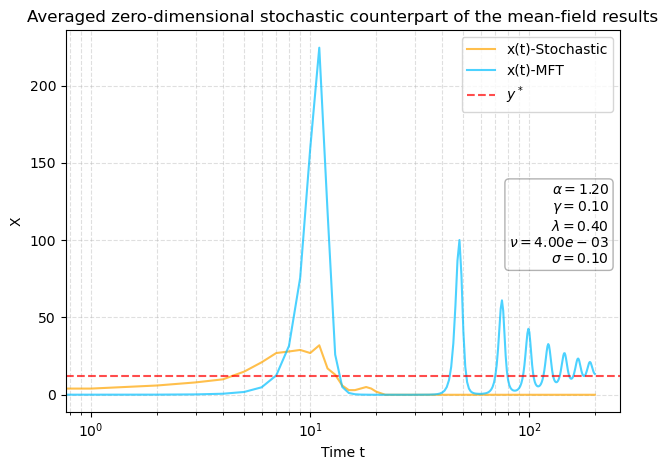

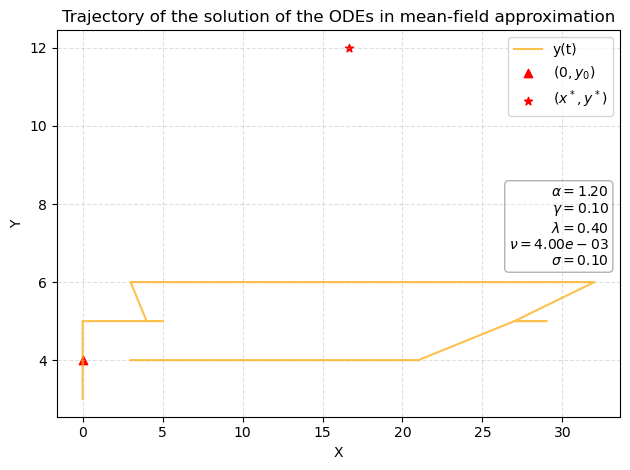

In [6]:
'''
par = {
    'alpha': 1.6,
    'gamma': 0.01,   # questo sarebbe 0.01
    'lambda': 0.6,
    'nu': 1.5e-3,
    'sigma': 0.01,
    'Dx': 0.,       # diffusion of x
    'Dy': 0.        # diffusion of y
}

par = {
    'alpha': 1.2,
    'gamma': 0.1,   # questo sarebbe 0.01
    'lambda': 0.4,
    'nu': 0.004,
    'sigma': 0.1,
    'Dx': 0.,       # diffusion of x
    'Dy': 0.        # diffusion of y
}
'''

# In which regime are we?
print(f'In which regime are we? {'First regime:(0,y_0) unstable, (x^*,y^*) stable' \
    if par['alpha']>(par['lambda']*par['gamma']/par['sigma']) else '\text{Second regime:}(0,y_0) \text{stable}, (x^*,y^*) \text{unstable}'}')



def lattice1(N:int,time_steps:int,par:dict):
    # N: number of cells (default=100)
    
    # Define the lattice
    lattice = np.zeros((N,2))

    # Inizialization    (x_i,y_0) for each site, with x_i = 3, y_0 = \lambda / \sigma
    lattice[:,0] = 3    
    lattice[:,1] = par['lambda'] / par['sigma']

    # Initialize arrays to contain the mean of x and y
    X_stoc = np.zeros(time_steps)
    Y_stoc = np.zeros(time_steps)

    # Loop
    for t in range(time_steps):
        for i in range(len(lattice)):
            lattice[i,0] += np.random.poisson(par['alpha']*lattice[i,0])                # proliferation of the pathogen
            lattice[i,1] += np.random.poisson(par['lambda'])                            # birth of lymphocyte
            lattice[i,0] -= np.random.poisson(par['gamma']*lattice[i,0]*lattice[i,1])   # lymphocyte kills pathogen
            check_sign(lattice[i,:])                                                    # check the sign only after there's a subtraction
            lattice[i,1] += np.random.poisson(par['nu']*lattice[i,0]*lattice[i,1])      # lymphocyte duplication
            lattice[i,1] -= np.random.poisson(par['sigma']*lattice[i,1])
            check_sign(lattice[i,:])

            # calculate the mean of x and y, so to compare it to the mean-field result
            X_stoc[t] = np.floor(np.mean(lattice[:,0]))                                 # floor so that it's alwasy an int 
            Y_stoc[t] = np.floor(np.mean(lattice[:,1]))
        
        #print(*lattice)                                                                # the asterisk in the print is used to print horizontally
    return X_stoc, Y_stoc 

# Compute the model
X_stoc, Y_stoc = lattice1(N=100,time_steps=time_steps,par=par)

# plot the evolution of x(t)
#plt.figure(figsize=(12,8))
plt.plot(X_stoc,c='orange',label='x(t)-Stochastic',alpha=0.7)
plt.plot(X_ode,c='deepskyblue',label='x(t)-MFT',alpha=0.7)
plt.axhline(y_star,c='r',linestyle='--',label=r'$y^*$',alpha=0.7)
plt.title('Averaged zero-dimensional stochastic counterpart of the mean-field results')
plt.xlabel('Time t')
plt.ylabel('X')
plt.xscale('log')
plt.grid(True, which="both",alpha=0.4,linestyle='--')
# Create a box plot for the parameters in 'par'
add_par_box(par)
plt.legend()
plt.tight_layout()
plt.show()

# Provo a plottare y(x) per vedere se capisco il problema
plt.plot(X_stoc, Y_stoc, c='orange', label='y(t)',alpha=0.7)
plt.title('Trajectory of the solution of the ODEs in mean-field approximation')
plt.scatter(0,y0, c='r',marker='^',label=r'$(0,y_0)$')
plt.scatter(x_star,y_star, c='r',marker='*',label=r'$(x^*,y^*)$')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True, which="both",alpha=0.4,linestyle='--')
# Create a box plot for the parameters in 'par'
add_par_box(par)
plt.legend()
plt.tight_layout()
plt.show()

Now I study the disappearance probability at the first pass near zero as a function of the distance between the two stable points.\
I only check for having zero pathogen for the zero-pathogen absorbing state; for now I don't care about Y.

Distance #0......
Distance #1......
Distance #2......
Distance #3......
Distance #4......
Distance #5......
Distance #6......
Distance #7......
Distance #8......
Distance #9......


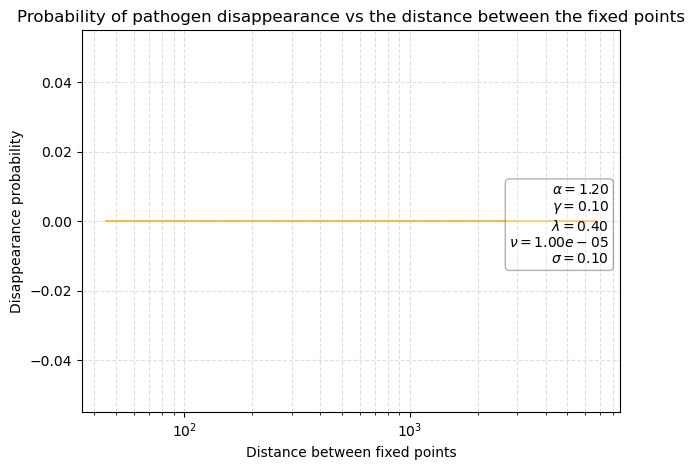

In [ ]:
def P_diss(model,num_nu:int,n_iter:int,N:int,time_steps:int,par:dict):
    # Loop over nu, from 1e-5 to 1.5e-3
    nu_values = np.linspace(1e-5,1.5e-3,num_nu)[::-1]                   # I invert the array (doing [::-1] because the distance is inversly proportional to nu)

    # set the time span 
    t_s = np.linspace(0,time_steps,time_steps) 
    
    # Initialize storing for disapperance probability
    P_d = np.zeros((num_nu,2))
    
    # Compute the distance between the two fixed points for each value of nu
    P_d[:,0] = [np.linalg.norm(np.array([0,par['lambda']/par['sigma']])-
                               np.array([(par['sigma']-par['lambda']*par['gamma']/par['alpha'])/nu,par['alpha']/par['gamma']])) 
                                for nu in nu_values]

    for i,nu in enumerate(nu_values):
        print(f'Distance #{i}...')
        par['nu'] = nu
        for iter in range(n_iter):
            '''
            X_stoc, Y_stoc = lattice1(N=N,time_steps=time_steps,par=par)
            # Define the first pass near-zero (as the point in which y(x) passes closest to (0,y0))
            #t_c = np.argmin(np.linalg.norm(np.array([0,y0]).reshape(2, 1) - np.array([X_stoc, Y_stoc]), axis=0))
            #if np.isclose(X_stoc[np.argmin(np.abs(Y_stoc - par['alpha']/par['gamma']))],0.0,1e-15):                        # I use np.isclose bc with the == always gives problems
            if np.isclose(X_stoc[100],0.0,1e-15):                               # so i take the first time y goes close to alpha/gamma
                P_d[i,1] += 1                                          # check if pathogen dissappeared
            '''
            X_ode = odeint(system,z0,t_s,args=(par,))[:,0]
            if np.isclose(X_ode[-1],0.0,1e-15):                               # so i take the first time y goes close to alpha/gamma
                P_d[i,1] += 1                                          # check if pathogen dissappeared
        P_d[i,1] /= n_iter                                              # compute the disappearence probability as success/total
    return P_d
    
'''    
# I try to compute a kinda of disappearance probability as the time it takes to reach zero-pathogen 
# (normalized with the maximum of such time and then inverted, i.e. P=1 for the minimum time)
def P_diss(model,num_nu:int,n_iter:int,N:int,time_steps:int,par:dict):
    # Loop over nu, from 1e-5 to 1.5e-3
    nu_values = np.linspace(1e-5,1.5e-3,num_nu)[::-1]                   # I invert the array (doing [::-1] because the distance is inversly proportional to nu)

    # set the time span 
    t_s = np.linspace(0,time_steps,time_steps) 
    
    # Initialize storing for disapperance probability
    P_d = np.zeros((num_nu,2))
    
    # Compute the distance between the two fixed points for each value of nu
    P_d[:,0] = [np.linalg.norm(np.array([0,par['lambda']/par['sigma']])-
                               np.array([(par['sigma']-par['lambda']*par['gamma']/par['alpha'])/nu,par['alpha']/par['gamma']])) 
                                for nu in nu_values]

    for i,nu in enumerate(nu_values):
        print(f'Distance #{i}......')
        par['nu'] = nu
        for iter in range(n_iter):
            X_stoc, _ = lattice1(N=N,time_steps=time_steps,par=par) 
            if np.where(X_stoc == 0.) == None:
                aux.checkpoint(True,msg='The system does not reach zero-pathogen state, not enough time steps',stop=True)                
            P_d[i,1] += np.where(X_stoc == 0.)[0][0]                    # With this I add to P_d the time value at which it reached zero-pathogen for the first time                                                                        
        P_d[i,1] /= n_iter                                              # Compute the disappearence probability as success/total
    P_d[:,1] -= np.min(P_d[:,1])                                        # Subtract the minumum so that the minimum value is shifted to 0
    P_d[:,1] /= np.max(P_d[:,1])                                        # Normalize with maximum
    P_d[:,1] = 1 - P_d[:,1]                                             # This is done to invert the time values, because the probability is inversly proportional to the time
                                                                        # (we do 1-P_d[:,1] because the time have been normalized and so they go from 0 to 1)
    return P_d
'''
'''
par = {
    'alpha': 1.2,
    'gamma': 0.1,   # questo sarebbe 0.01
    'lambda': 0.4,
    'nu': 1e-5,
    'sigma': 0.1,
    'Dx': 0.,       # diffusion of x
    'Dy': 0.        # diffusion of y
}
'''
# Compute the disapperance probability
P_d = P_diss(model=lattice1,num_nu=10,n_iter=10,N=100,time_steps=time_steps,par=par)

# plot the evolution of x(t)
#plt.figure(figsize=(12,8))
plt.plot(P_d[:,0],P_d[:,1],c='orange',alpha=0.7)
plt.title('Probability of pathogen disappearance vs the distance between the fixed points')
plt.xlabel('Distance between fixed points')
plt.ylabel('Disappearance probability')
plt.xscale('log')
plt.grid(True, which="both",alpha=0.4,linestyle='--')
add_par_box(par)
plt.tight_layout()
plt.show()
